In [290]:
import yfinance as yt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [291]:
# download data
ticker = "IBM"
df = yt.download(ticker, start = "2012-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,178.518158,180.411087,177.820267,178.107071,118.534370,5905716
2012-01-04,177.409180,178.135757,176.806885,177.380493,118.050819,4546648
2012-01-05,176.682602,176.892929,175.047806,176.539200,117.490875,4668403
2012-01-06,176.281067,176.367111,174.292542,174.512421,116.142082,5122367
2012-01-09,174.187378,174.254303,172.342255,173.604202,115.537628,5440455


Text(0, 0.5, 'Close price')

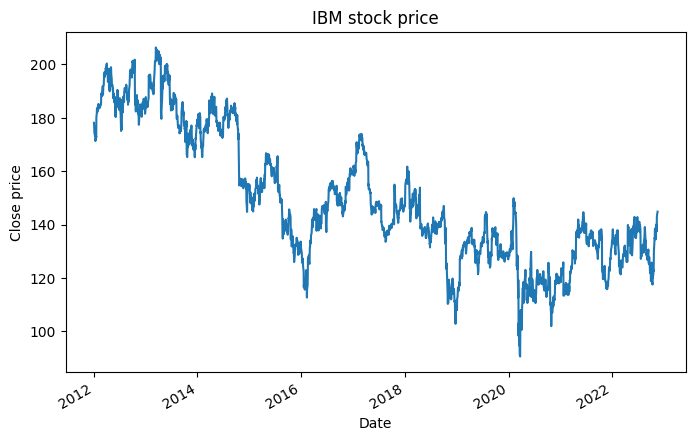

In [292]:
# plot data
fig = plt.figure()
ax = fig.add_subplot(111)
df["Close"].plot(figsize = (8, 5))
plt.title("{} stock price".format(ticker))
plt.ylabel("Close price")

In [293]:
# simple strat based on open and close each day
for i, row in df.iterrows():
    if(row["Open"] - row["Close"] < 0):
        df.at[i, "simple_strat_position"] = 1
    else:
        df.at[i, "simple_strat_position"] = -1

In [294]:
# implement simple strat
df["daily_change"] = df["Close"] - df["Open"] # change in value over the day
df["profit_simple_strat"] = df.simple_strat_position.shift(1) * df.daily_change # profit on one day is change in value of that day multiplied by our position
df["return_simple_strat"] = df["profit_simple_strat"].cumsum() # total returns of strategy
df["return_holding_stock"] = [(i-df.iloc[0]["Open"]) for i in df.Open] # return from buying and holding

Text(0, 0.5, 'Returns')

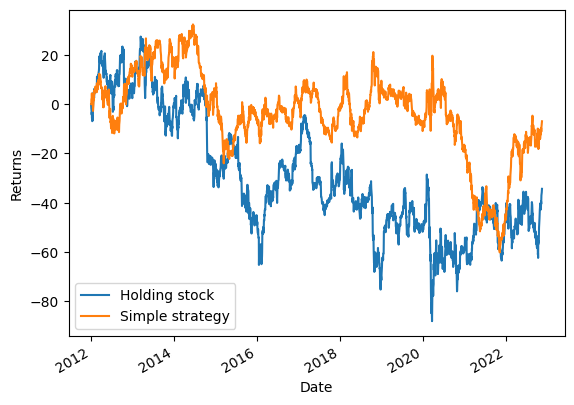

In [295]:
# plot our strat vs holding
df.plot(y = ["return_holding_stock", "return_simple_strat"], label = ["Holding stock", "Simple strategy"])
plt.ylabel("Returns")

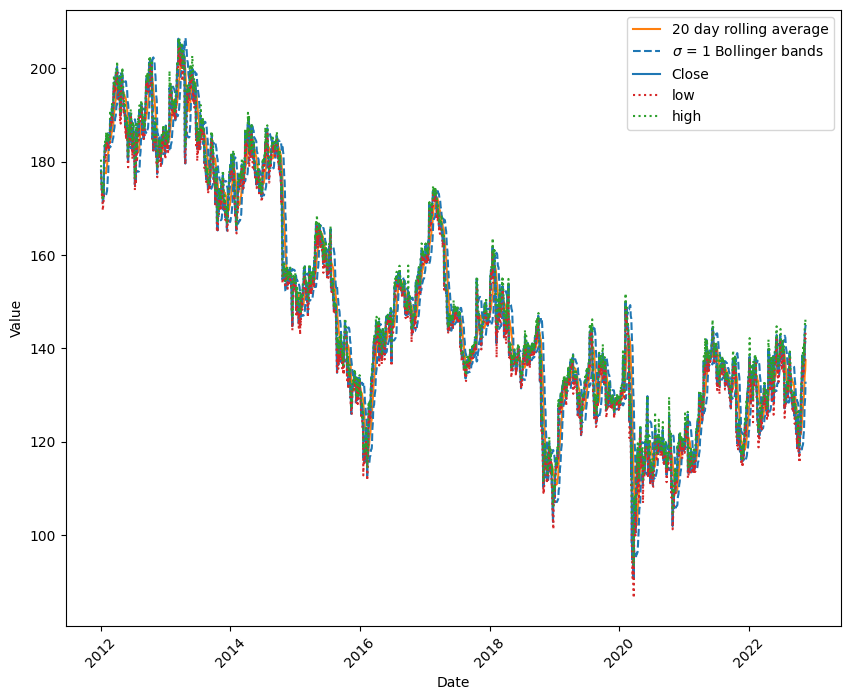

In [296]:
# Calculate Bollinger bands with N = 20 and K = 2
N = 20
K = 1
df["rolling_mean"] = df["Close"].rolling(window=N).mean()
df["rolling_std"] = df["Close"].rolling(window=N).std()
df["lower_bollinger"] = df.rolling_mean - K * df.rolling_std
df["upper_bollinger"] = df.rolling_mean + K * df.rolling_std

# plot graph
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)
blue = '#1f77b4'
orange = '#ff7f0e'
red = '#d62728'
green = '#2ca02c'
ax.plot(df.rolling_mean.index, df.rolling_mean, label = "{} day rolling average".format(N), color = orange)
ax.plot(df.lower_bollinger.index, df.lower_bollinger, linestyle = "--", color = blue, label = r"$\sigma$ = {} Bollinger bands".format(K))
ax.plot(df.upper_bollinger.index, df.upper_bollinger, linestyle = "--", color = blue)
ax.plot(df.index, df["Close"], label = "Close", color = blue)
ax.plot(df.index, df["Low"], linestyle = ":", color = red, label = "low")
ax.plot(df.index, df["High"], linestyle = ":", color = green, label = 'high')
ax.set_ylabel("Value")
ax.set_xlabel("Date")
ax.legend()
plt.xticks(rotation = 45)
plt.show()


In [321]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
total_long_positions = 0
total_short_positions = 0
r = 0.1
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "profit_bollinger_strat"] = 0
    else:

        # if low falls below lower band
        if(df.at[i, "Low"] < df.at[i, "lower_bollinger"]):

            low = df.at[i, "Low"]
            close = df.at[i, "Close"]

            # if we have a short pos and we can profit, close it
            if short_pos and short_price > low:
                short_pos = False
                total_short_positions -= 1
                df.at[i, "profit_bollinger_strat"] = short_price - close
            else:
                df.at[i, "profit_bollinger_strat"] = 0

            # if we don't have a long position, open one
            if not long_pos:
                long_pos = True
                long_price = close
                total_long_positions += 1
                long_date = i

        # if high goes above upper band
        elif(df.at[i, "High"] > df.at[i, "upper_bollinger"]):

            high = df.at[i, "High"]
            close = df.at[i, "Close"]

            # if we have a long pos and we can profit, close it
            if long_pos and high > long_price:
                long_pos = False
                total_long_positions -= 1
                df.at[i, "profit_bollinger_strat"] = close - long_price
            else:
                df.at[i, "profit_bollinger_strat"] = 0

            # open short pos
            if not short_pos:
                short_pos = True
                short_price = close
                total_short_positions += 1
                short_date = i

        # if price falls 10% below long, close position and take loss
        elif(df.at[i, "High"] < (1-r)*long_price and long_pos):
            df.at[i, "profit_bolligner_strat"] = df.at[i, "Close"] - long_price
            long_pos = False
            total_long_positions -= 1

        # if price rises 10% above short, close position and take loss
        elif(df.at[i, "High"] > (1+r)*short_price and short_pos):
            df.at[i, "profit_bolligner_strat"] = short_price - df.at[i, "Close"]
            short_pos = False
            total_short_positions -= 1

        # if between bands
        else:
            df.at[i, "profit_bollinger_strat"] = 0

    counter += 1

# find cummulative returns
df["return_bollinger_strat"] = df["profit_bollinger_strat"].cumsum()

# check for open and close positions
if total_long_positions > 0:
    print("Warning: {} open long position(s)".format(total_long_positions))
    print(short_date)
if total_short_positions > 0:
    print("Warning: {} open short position(s)".format(total_short_positions))
    print(long_date)


2022-08-26 00:00:00


Text(0, 0.5, 'Returns')

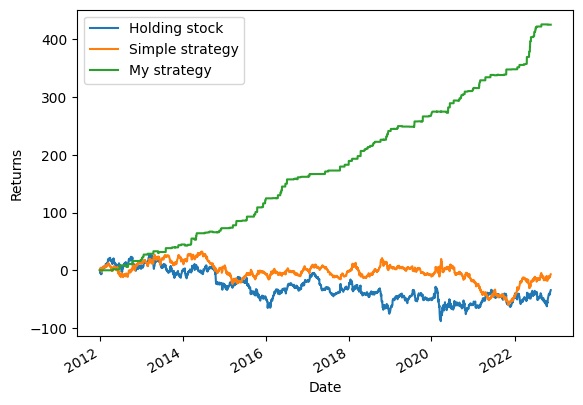

In [322]:
df.plot(y = ["return_holding_stock", "return_simple_strat", "return_bollinger_strat"], label = ["Holding stock", "Simple strategy", "My strategy"])
plt.ylabel("Returns")

# Final Strategy

The above bolligner strategy assumed that we knew the high and low for each day at the precise moment it happened. This is unrealistic so below we implement a better strategy. We use the high and the low of the previous day to trigger signal, the next day we then trade based off of those signal. The result is essentially the same which is good, but this is an actual executable trading strategy.

In [315]:
# create strategy based off bolinger bands
counter = 0
long_pos = False
short_pos = False
total_long_positions = 0
total_short_positions = 0
trades_made = 0
r = 0.1
for i, row in df.iterrows():

    # do nothing for the first 20 days
    if counter < N:
        df.at[i, "bolligner_long_signal"] = 0
        df.at[i, "bolligner_short_signal"] = 0
    else:

        # if low falls below lower band
        if(df.at[i, "Low"] < df.at[i, "lower_bollinger"]):

            low = df.at[i, "Low"]
            close = df.at[i, "Close"]

            # if we have a short pos and we can profit, close it
            if short_pos and short_price > low:
                short_pos = False
                total_short_positions -= 1
                df.at[i, "bolligner_short_signal"] = -1
                trades_made += 1
            else:
                df.at[i, "bolligner_short_signal"] = 0

            # if we don't have a long position, open one
            if not long_pos:
                df.at[i, "bolligner_long_signal"] = 1
                long_pos = True
                long_price = close
                total_long_positions += 1
                long_date = i
                trades_made += 1
            else:
                df.at[i, "bolligner_long_signal"] = 0

        # if high goes above upper band
        elif(df.at[i, "High"] > df.at[i, "upper_bollinger"]):

            high = df.at[i, "High"]
            close = df.at[i, "Close"]

            # if we have a long pos and we can profit, close it
            if long_pos and high > long_price:
                long_pos = False
                total_long_positions -= 1
                df.at[i, "bolligner_long_signal"] = -1
                trades_made += 1
            else:
                df.at[i, "profit_bollinger_strat"] = 0

            # open short pos
            if not short_pos:
                df.at[i, "bolligner_short_signal"] = 1
                short_pos = True
                short_price = close
                total_short_positions += 1
                short_date = i
                trades_made += 1

        # if price falls 10% below long, close position and take loss
        if(df.at[i, "High"] < (1-r)*long_price and long_pos):
            df.at[i, "bolligner_long_signal"] = -1
            df.at[i, "bolligner_short_signal"] = 0
            long_pos = False
            total_long_positions -= 1
            trades_made += 1

        # if price rises 10% above short, close position and take loss
        elif(df.at[i, "High"] > (1+r)*short_price and short_pos):
            df.at[i, "bolligner_short_signal"] = -1
            df.at[i, "bolligner_long_signal"] = 0
            short_pos = False
            total_short_positions -= 1
            trades_made += 1

        # if between bands
        else:
            df.at[i, "bolligner_long_signal"] = 0
            df.at[i, "bolligner_short_signal"] = 0

    counter += 1

# check for open and close positions
if total_long_positions > 0:
    print("Warning: {} open long position(s)".format(total_long_positions))
    print(short_date)
if total_short_positions > 0:
    print("Warning: {} open short position(s)".format(total_short_positions))
    print(long_date)

print("Total trades made = {}".format(trades_made))

2022-08-26 00:00:00
Total trades made = 365


In [316]:
# shirt signal by one day
df.bolligner_short_signal.shift(1)
df.bolligner_long_signal.shift(1)

count = 0

# calculate returns
for i, row in df.iterrows():

    # assume nothing happens that day
    df.at[i, "profit_bolligner_strat_2"] = 0

    # if opening long pos
    if df.at[i, "bolligner_long_signal"] == 1:
        long_price = df.at[i, "open"]
        count += 1
    # closing long pos
    elif df.at[i, "bolligner_long_signal"] == -1:
        df.at[i, "profit_bolligner_strat_2"] += df.at[i, "Open"] - long_price
        count += 1

    # if opening short pos
    if df.at[i, "bolligner_short_signal"] == 1:
        short_price = df.at[i, "open"]
        count += 1
    # closing long pos
    elif df.at[i, "bolligner_short_signal"] == -1:
        count += 1
        df.at[i, "profit_bolligner_strat_2"] += short_price - df.at[i, "Open"]

print(count)

# calculate cummulative returns
df["return_bollinger_strat_2"] = df.profit_bolligner_strat_2.cumsum()

26


Text(0.5, 1.0, 'IBM strategy comparison')

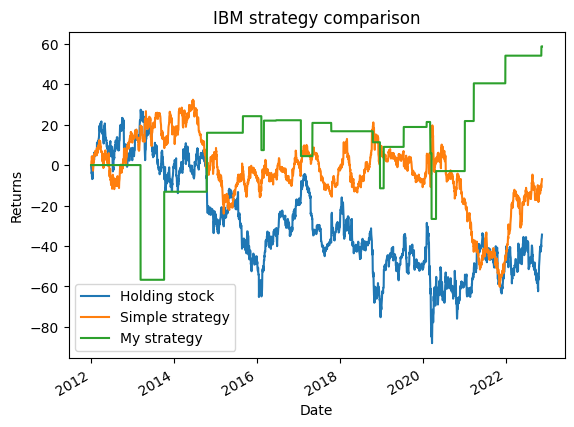

In [307]:
df.plot(y = ["return_holding_stock", "return_simple_strat", "return_bollinger_strat_2"], label = ["Holding stock", "Simple strategy", "My strategy"])
plt.ylabel("Returns")
plt.title("{} strategy comparison".format(ticker))

In [ ]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,simple_strat_position,daily_change,profit_simple_strat,return_simple_strat,return_holding_stock,rolling_mean,rolling_std,lower_bollinger,upper_bollinger,bolligner_long_signal,bolligner_short_signal,profit_bollinger_strat,profit_bolligner_strat,return_bollinger_strat
Date,,,,,,,,,,,,,,,,,,,,
2022-11-10,140.259995,141.369995,138.289993,141.229996,141.229996,5389000,1.0,0.970001,-0.970001,-11.186974,-38.258163,133.043499,6.620977,126.422522,139.664475,0.0,0.0,0.0,0.000000,0.0
2022-11-11,141.500000,144.130005,140.960007,143.169998,143.169998,5869400,1.0,1.669998,1.669998,-9.516975,-37.018158,134.199998,6.239157,127.960841,140.439155,0.0,-1.0,0.0,4.580002,0.0
2022-11-14,142.630005,146.080002,142.179993,144.199997,144.199997,5293500,1.0,1.569992,1.569992,-7.946983,-35.888153,135.333998,5.862965,129.471033,141.196964,0.0,0.0,0.0,0.000000,0.0
2022-11-15,144.080002,146.160004,142.000000,144.339996,144.339996,4726800,1.0,0.259995,0.259995,-7.686989,-34.438156,136.403998,5.417864,130.986134,141.821862,0.0,0.0,0.0,0.000000,0.0
2022-11-16,144.130005,144.850006,144.008102,144.600006,144.600006,1649524,1.0,0.470001,0.470001,-7.216988,-34.388153,137.508498,4.630817,132.877682,142.139315,0.0,0.0,0.0,0.000000,0.0
